In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [26]:
# Load data
train_peptides = pd.read_csv("/content/train_peptides.csv")
train_proteins = pd.read_csv("/content/train_proteins.csv")
train_clinical_data = pd.read_csv("/content/train_clinical_data.csv")

In [27]:
train_peptides.head(5)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [28]:
train_proteins.head(5)

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [29]:
train_clinical_data.head(5)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [30]:
# Feature engineering
def feature_engineering(peptides, proteins, clinical_data):
    # Merge datasets
    peptides_agg = peptides.groupby(['visit_id', 'UniProt'])['PeptideAbundance'].mean().reset_index()
    proteins_agg = proteins.groupby(['visit_id', 'UniProt'])['NPX'].mean().reset_index()

    data = pd.merge(clinical_data, peptides_agg, on='visit_id', how='left')
    data = pd.merge(data, proteins_agg, on=['visit_id', 'UniProt'], how='left')

    # Create additional features
    data['PeptideAbundance_NPX_ratio'] = data['PeptideAbundance'] / data['NPX']

    # Drop unnecessary columns
    data.drop(columns=['visit_id', 'patient_id', 'UniProt'], inplace=True)

    # Fill missing values
    data.fillna(data.mean(), inplace=True)

    return data


In [31]:
processed_data = feature_engineering(train_peptides, train_proteins, train_clinical_data)

<ipython-input-30-dde88643c7b0>:17: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


<ipython-input-32-59744f0ae9cd>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(processed_data.corr(), annot=True, cmap='coolwarm')


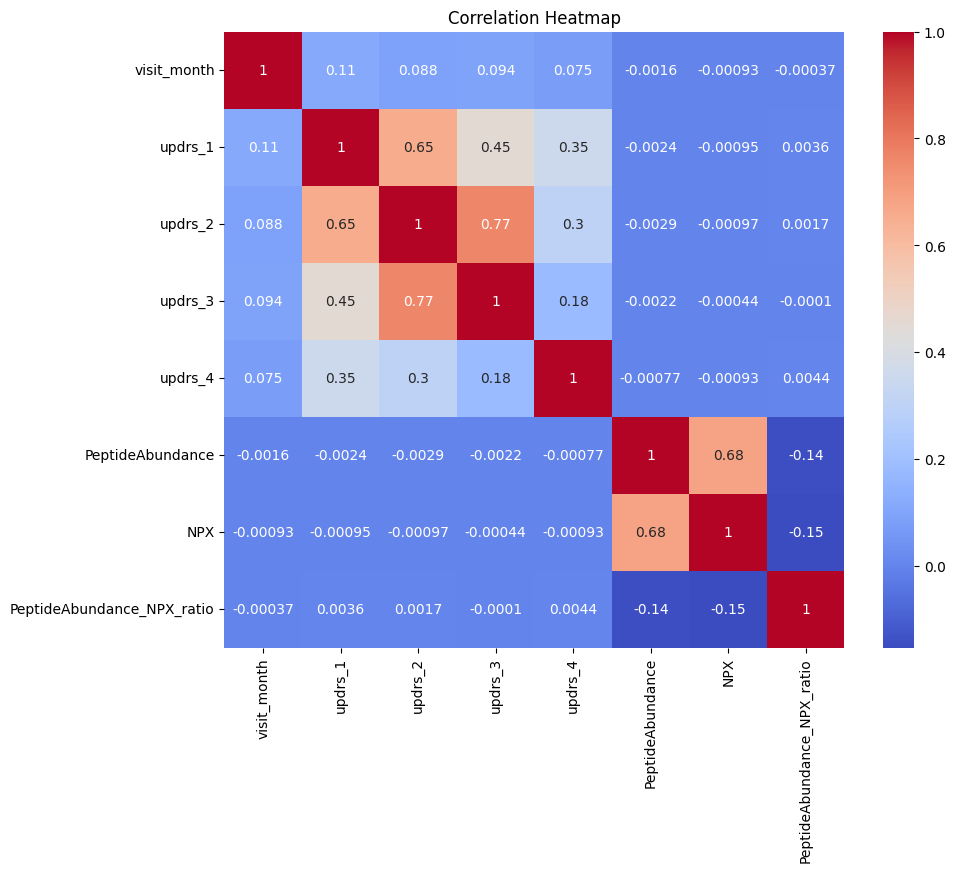

In [32]:
# Visualization: Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(processed_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

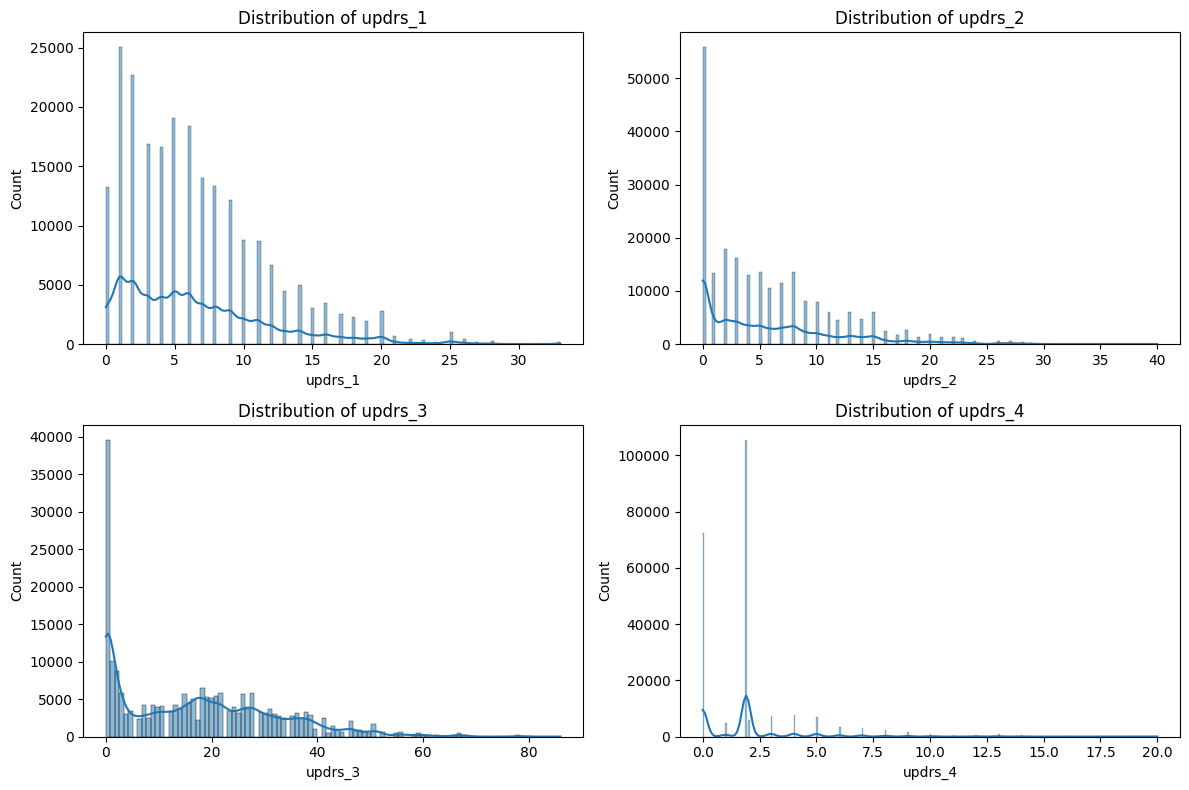

In [33]:
# Visualization: Distribution of target variables
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, target in enumerate(["updrs_1", "updrs_2", "updrs_3", "updrs_4"]):
    sns.histplot(data=processed_data, x=target, kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f"Distribution of {target}")
plt.tight_layout()
plt.show()

In [34]:
processed_data.head(5)

,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,PeptideAbundance,NPX,PeptideAbundance_NPX_ratio
0,0,10.0,6.0,15.0,1.905113,NaN,11254.300,11254.3,1.000000
1,0,10.0,6.0,15.0,1.905113,NaN,91553.775,732430.0,0.125000
2,0,10.0,6.0,15.0,1.905113,NaN,19792.900,39585.8,0.500000
3,0,10.0,6.0,15.0,1.905113,NaN,41526.900,41526.9,1.000000
4,0,10.0,6.0,15.0,1.905113,NaN,15619.025,31238.0,0.500001


In [35]:
# Prepare data for training
X = processed_data.drop(columns=["updrs_1", "updrs_2", "updrs_3", "updrs_4","upd23b_clinical_state_on_medication"])
y = processed_data[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]]

In [36]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
# Define model
model = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(random_state=42))
])

In [38]:
# Train model
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(random_state=42))])

In [39]:
# Validate model
y_pred = model.predict(X_val)
score = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {score}")


Validation RMSE: 8.059673069781029


In [45]:
# Create a new DataFrame to store the validation predictions
val_submission = X_val.reset_index().rename(columns={'index': 'visit_id'})
val_submission[['updrs_1_pred', 'updrs_2_pred', 'updrs_3_pred', 'updrs_4_pred']] = y_pred

# Keep only the desired columns
val_submission = val_submission[['visit_id', 'updrs_1_pred', 'updrs_2_pred', 'updrs_3_pred', 'updrs_4_pred']]
val_submission.head(5)

# Save submission to CSV
val_submission.to_csv('submission.csv', index=False)


